<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [186]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [187]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-10-08 20:54:19--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2020-10-08 20:54:19 (12.7 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [188]:
df = pd.read_csv('loan_train.csv')
df.head(2)

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female


In [189]:
df.shape

(346, 10)

### Convert to date time object 

In [190]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])

#counting to see how may PAIDOFF and how many went to COLLECTION
df['loan_status'].value_counts()


#260 people PAIDOFF and 86 went to Collection

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

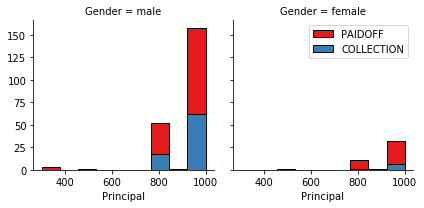

In [191]:
#Plotting graphs

import seaborn as sns

# Principle loan vs gender

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()




In [192]:
#convert education to numerical format
# High School or Below = 0
# Bechalor = 1
# college = 2

df.education.replace(to_replace=['High School or Below','Bechalor','college','Master or Above'], value=[0,1,2,3],inplace=True)


In [193]:
#Convert the Gender to numerical format
#df.Gender.replace(to_replace=['male','female'], value=[1,0], inplace=True)
df.Gender.head(3)


0      male
1    female
2      male
Name: Gender, dtype: object

In [194]:
# Check all the data to make sure everything is numerical

df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,0,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,1,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,2,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,2,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,2,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

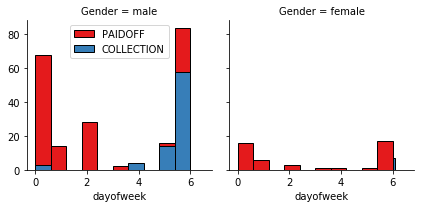

In [195]:
#Day of the week people get the loan

df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=10, ec="k")
g.axes[-2].legend()
plt.show()

#Most people get paid at the end of the week and don't pay it
#Male = 1 and Female = 0

In [196]:

print('86 % of female pay there loans while only 73 % of males pay there loan')

df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

86 % of female pay there loans while only 73 % of males pay there loan


Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

In [197]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

# Regardless of education, it appears that quarter of people don't pay their loan

education  loan_status
0          PAIDOFF        0.741722
           COLLECTION     0.258278
1          PAIDOFF        0.750000
           COLLECTION     0.250000
2          PAIDOFF        0.765101
           COLLECTION     0.234899
3          COLLECTION     0.500000
           PAIDOFF        0.500000
Name: loan_status, dtype: float64

In [198]:
#Train Test Split
'''
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.2, random_state =4)
print('Train set', X_train.shape, y_train.shape)
print('Test set',X_test.shape, y_test.shape)
'''
      

"\nfrom sklearn.model_selection import train_test_split\n\nX_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.2, random_state =4)\nprint('Train set', X_train.shape, y_train.shape)\nprint('Test set',X_test.shape, y_test.shape)\n"

In [199]:
'''
from sklearn.neighbors import KNeighborsClassifier
k = 4

#print('y type', y_train)

neigh = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
neigh

'''

"\nfrom sklearn.neighbors import KNeighborsClassifier\nk = 4\n\n#print('y type', y_train)\n\nneigh = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)\nneigh\n\n"

In [200]:
'''
yhat = neigh.predict(X_test)
yhat[0:5]
'''

'\nyhat = neigh.predict(X_test)\nyhat[0:5]\n'

In [201]:
'''
#Accuracy Evaluation
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

'''

'\n#Accuracy Evaluation\nfrom sklearn import metrics\nprint("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))\nprint("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))\n\n'

In [202]:
'''
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

'''

'\n# notice: installing seaborn might takes a few minutes\n!conda install -c anaconda seaborn -y\n\n'

In [203]:
'''
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()
'''

'\nimport seaborn as sns\n\nbins = np.linspace(df.Principal.min(), df.Principal.max(), 10)\ng = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)\ng.map(plt.hist, \'Principal\', bins=bins, ec="k")\n\ng.axes[-1].legend()\nplt.show()\n'

In [204]:
'''
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

'''

'\nbins = np.linspace(df.age.min(), df.age.max(), 10)\ng = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)\ng.map(plt.hist, \'age\', bins=bins, ec="k")\n\ng.axes[-1].legend()\nplt.show()\n\n'

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

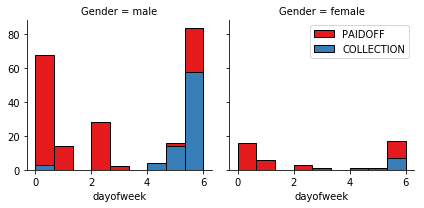

In [205]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [206]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,0,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,1,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,2,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,2,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,2,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [207]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [208]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)


## One Hot Encoding  
#### How about education?

In [209]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education  loan_status
0          PAIDOFF        0.741722
           COLLECTION     0.258278
1          PAIDOFF        0.750000
           COLLECTION     0.250000
2          PAIDOFF        0.765101
           COLLECTION     0.234899
3          COLLECTION     0.500000
           PAIDOFF        0.500000
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [210]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,0
1,1000,30,33,1,1
2,1000,15,27,0,2
3,1000,30,28,1,2
4,1000,30,29,0,2


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [211]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
#Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,0,1,2,3
0,1000,30,45,0,0,1,0,0,0
1,1000,30,33,1,0,0,1,0,0
2,1000,15,27,0,0,0,0,1,0
3,1000,30,28,1,1,0,0,1,0
4,1000,30,29,0,1,0,0,1,0


### Feature selection

Lets defind feature sets, X:

In [212]:
# Defining the X values

X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,0,1,2,3
0,1000,30,45,0,0,1,0,0,0
1,1000,30,33,1,0,0,1,0,0
2,1000,15,27,0,0,0,0,1,0
3,1000,30,28,1,1,0,0,1,0
4,1000,30,29,0,1,0,0,1,0


What are our lables?

In [213]:
#Defining the y values
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [214]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
         1.13639374, -0.38170062, -0.86968108, -0.07624929],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
        -0.87997669,  2.61985426, -0.86968108, -0.07624929],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.87997669, -0.38170062,  1.14984679, -0.07624929],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.87997669, -0.38170062,  1.14984679, -0.07624929],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.87997669, -0.38170062,  1.14984679, -0.07624929]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [215]:
#KNN

from sklearn.neighbors import KNeighborsClassifier
k = 6
#Training the Model and Predicting 
knn_ = KNeighborsClassifier(n_neighbors = k)
knn_.fit(X,y)
knn_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=6, p=2,
           weights='uniform')

In [216]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
tree.fit(X,y)
tree


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [217]:
# Support Vector Machine

from sklearn import svm
sv_machine = svm.SVC(kernel='linear')
sv_machine.fit(X, y)
sv_machine

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [218]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(C=0.0001, solver='liblinear')
log_reg.fit(X,y)
log_reg

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [219]:
# Model Evaludation
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


In [220]:
# Load the loan_test csv data
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

test_df = pd.read_csv('loan_test.csv')
test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,0],inplace=True)
test_df.head()

--2020-10-08 20:54:47--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-10-08 20:54:47 (419 MB/s) - ‘loan_test.csv’ saved [3642/3642]



,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,1,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,1,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,1,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,1,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,1,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [221]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

test_df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,50,1,Bechalor
1,300,7,35,0,Master or Above
2,1000,30,43,1,High School or Below
3,1000,30,26,0,college
4,800,15,29,0,Bechalor


In [222]:
Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)
Feature_test.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [223]:
X_test = Feature_test
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)
X_test[0:5]

X_test.shape

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


(54, 8)

In [224]:
# Y values
from sklearn import metrics

y_test = test_df['loan_status'].values
print(type(y_test))
#print(test_df['loan_status'])
#test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,0],inplace=True)

y_test[0:5]

y_test.shape


<class 'numpy.ndarray'>


(54,)

In [225]:
# Calculate accuracy scores for each metric method 
# Knn prediction

neigh = KNeighborsClassifier(n_neighbors=k).fit(X_test, y_test)
neigh

#Predict y hat
yhat = neigh.predict(X_test)
print(yhat[0:5])



#print("Train set KNN Accuracy: ", metrics.accuracy_score(y, neigh.predict(X)))
#print("Test set KNN Accuracy: ", metrics.accuracy_score(y_test, yhat))
jaccard_neigh = jaccard_similarity_score(y_test,yhat)
print('KNN jaccard score is ',jaccard_neigh, ' which is about', round(jaccard_neigh*100),"%")

#from sklearn.metrics import f1_score
#print('f1 score ',f1_score_neigh = f1_score(y_test, yhat))
#print('KNN F1 score is ',f1_score_neigh,'which is around', round(f1_score(y_test, yhat)*100),'%')

[1 1 0 1 1]
KNN jaccard score is  0.7962962962962963  which is about 80.0 %


In [227]:

from sklearn.metrics import f1_score

#yhat.replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,0],inplace=True)


print(yhat)


print(f1_score(y_test, yhat))
print('F1 score is ', round(f1_score(y_test, yhat)*100),'%')


[1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 0 0 0 1 0 0 1 0 1 0 0 0 1 0]
0.8571428571428571
F1 score is  86.0 %


In [233]:
# Decision Tree

In [228]:
#Modeling of Decision Tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
approveLoan = DecisionTreeClassifier(criterion="entropy", max_depth = 4)

approveLoan.fit(X_test,y_test)

#prediction
predTree = approveLoan.predict(X_test)


tree_jaccard = jaccard_similarity_score(y_test, yhat)
tree_f1_score = f1_score(y_test, yhat, average='weighted')

print(tree_jaccard)
print(tree_f1_score)
print('tree jaccard score is ',tree_jaccard, ' which is about', round(tree_jaccard*100),"%")
print('tree F1 score is ',tree_f1_score,'which is around', round(f1_score(y_test, yhat)*100),'%')

0.7962962962962963
0.802184673152415
tree jaccard score is  0.7962962962962963  which is about 80.0 %
tree F1 score is  0.802184673152415 which is around 86.0 %


In [229]:
# SVM

from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_test, y_test) 

yhat = clf.predict(X_test)
yhat [0:5]

print("Train set SVM Accuracy: ", metrics.accuracy_score(y, sv_machine.predict(X)))
print("Test set SVM Accuracy: ", metrics.accuracy_score(y_test, yhat))
sv_machine_jaccard = jaccard_similarity_score(y_test, yhat)
sv_machine_f1_score = f1_score(y_test, yhat, average='weighted')


print('SVM jaccard score is ',sv_machine_jaccard, ' which is about', round(sv_machine_jaccard*100),"%")
print('SVM F1 score is ',sv_machine_f1_score, ' which is about', round(sv_machine_f1_score*100),"%")



Train set SVM Accuracy:  0.7514450867052023
Test set SVM Accuracy:  0.8703703703703703
SVM jaccard score is  0.8703703703703703  which is about 87.0 %
SVM F1 score is  0.8539804171988081  which is about 85.0 %


In [230]:
#Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_test,y_test)
LR
yhat = LR.predict(X_test)
yhat

# Determining probablility
yhat_prob = LR.predict_proba(X_test)
yhat_prob[:5]

LR_jaccard = jaccard_similarity_score(y_test, yhat)
LR_f1_score = f1_score(y_test, yhat)


print('LR jaccard score is ',LR_jaccard, ' which is about', round(LR_jaccard*100),"%")
print('LR F1 score is ',LR_f1_score, ' which is about', round(LR_f1_score*100),"%")

print('log loss is ',log_loss(y_test, yhat_prob))

LR jaccard score is  0.7777777777777778  which is about 78.0 %
LR F1 score is  0.8461538461538461  which is about 85.0 %
log loss is  0.6355095172018215


In [232]:
#Confusion Matrix

from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))


[[33  7]
 [ 5  9]]


# Decision Tree

# Support Vector Machine

First, download and load the test set:

In [ ]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

### Load Test set for evaluation 

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.66     | 0.777      | NA      |
| Decision Tree      | 0.79     | 0.88       | NA      |
| SVM                | 0.79       | 0.88        | NA      |
| LogisticRegression | 0.79       | 0.88        | 0.601      |



<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>